# Results

This notebook shows how to work with the results from the joint Crab paper.

As explained in the [README.md](README.md), the main analysis and the figures for this paper were produced by Python scripts (`make.py` and `joint_crab` package). However, all results are stored in standard machine-readable formats (YAML for structured data, ECSV or FITS for tables) that are easy to read from Python.

In this notebook we will have a detailed look at the files in `results/fit`, and show how to compute a spectral results summary table (similar to Table 2 in the paper) as well as an illustration of the parameter contraints and errors from the fig (similar to Figure 4 in the paper).

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [27]:
import yaml
import numpy as np
import pandas as pd
from multinorm import MultiNorm
from astropy.table import Table

## Read YAML fit results

The fit results are given in the files `results/fit/fit_{name}.yaml`, where `name = {"fermi", "magic", "veritas", "fact", "hess", "joint"}`. As an example, you can look at [results/fit/fit_fermi.yaml](results/fit/fit_fermi.yaml) to see the structure. For each fit parameter, there's the name, value and error, and there's also the covariance matrix.

In [12]:
info = yaml.load(open('results/fit/fit_joint.yaml'))
info

{'parameters': [{'name': 'amplitude',
   'value': 3.8491280655591303e-11,
   'factor': 3.8491280655591305,
   'scale': '1e-11',
   'unit': 'cm-2 s-1 TeV-1',
   'min': nan,
   'max': nan,
   'frozen': False,
   'error': 1.143517011477271e-12},
  {'name': 'reference',
   'value': 1.0,
   'factor': 1.0,
   'scale': 1.0,
   'unit': 'TeV',
   'min': nan,
   'max': nan,
   'frozen': True,
   'error': 0.0},
  {'name': 'alpha',
   'value': 2.505373527966412,
   'factor': 2.505373527966412,
   'scale': 1.0,
   'unit': '',
   'min': nan,
   'max': nan,
   'frozen': False,
   'error': 0.025495081633449074},
  {'name': 'beta',
   'value': 0.23621061222240725,
   'factor': 2.3621061222240725,
   'scale': 0.1,
   'unit': '',
   'min': nan,
   'max': nan,
   'frozen': False,
   'error': 0.024508862873678088}],
 'covariance': [[1.3076311555379092e-24,
   0.0,
   1.2371786961404113e-16,
   1.160384141181053e-14],
  [0.0, 0.0, 0.0, 0.0],
  [1.2371786961404113e-16, 0.0, 0.0006499991874962324, 0.000492142

Usually you'll have to write a few lines of code to get the data in the form you want.

For example, here's how to put the parameter information into a `pandas.DataFrame`:

In [23]:
pd.DataFrame([
    {'name': _['name'], 'value': _['value'], 'error': _['error']}
    for _ in info["parameters"]
],
    columns=["name", "value", "error"],
)

,name,value,error
0,amplitude,3.849128e-11,1.143517e-12
1,reference,1.000000e+00,0.000000e+00
2,alpha,2.505374e+00,2.549508e-02
3,beta,2.362106e-01,2.450886e-02


The `yaml.load` call returns Python objects (str, float, list, dict). Often for computations you want a Numpy array. It's easy to make:

In [28]:
cov = np.array(info["covariance"])
cov

array([[1.30763116e-24, 0.00000000e+00, 1.23717870e-16, 1.16038414e-14],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.23717870e-16, 0.00000000e+00, 6.49999187e-04, 4.92142835e-04],
       [1.16038414e-14, 0.00000000e+00, 4.92142835e-04, 6.00684359e-04]])

## Check parameter correlations

If you look at Table 2 or Figure 4 in the paper, you will find that the parameter errors in the joint fit are much smaller than the parameter errors from each individual instrument dataset.

Why is that?

The reason is that there are strong correlations between the three fit parameters, especially for the Fermi-LAT dataset. The likelihood for each dataset is approximately a three-dimensional multivariate normal, and the joint likelihood is approximately the product of those likelihood, and the parameter correlations lead to a well-constrained joint likelihood.

Let's load all fit results and compute the product multivariate normal, and then create a Figure similar to Fig. 4 in the paper. We will use the `MultiNorm` class from the [multinorm](https://multinorm.readthedocs.io/) module to help a bit with the covariance matrix related computations.

### Load all results

First let's load all fit results, and store each one in a `MultiNorm` object:

In [35]:
def read_fit_result(name):
    data = yaml.load(open(f"results/fit/fit_{name}.yaml"))
    mean = [_["value"] for _ in data["parameters"]]
    cov = data["covariance"]
    # Use parameter names that are consistent with the paper
    names = ["phi", "reference", "gamma", "beta"]
    mn = MultiNorm(mean, cov, names)
    mn = mn.drop(["reference"])
    return mn

results = {
    name: read_fit_result(name) for name in 
    ("fermi", "magic", "veritas", "fact", "hess", "joint")   
}

### Check results

We can now do any covariance-matrix related computations, e.g. to compute parameter errors or correlations:

In [38]:
# These are the numbers in the last row in Table 2 in the paper
results["joint"].parameters

,mean,err
name,,
phi,3.849128e-11,1.143517e-12
gamma,2.505374e+00,2.549508e-02
beta,2.362106e-01,2.450886e-02


In [42]:
# The parameter correlations for Fermi-LAT are very high
results["fermi"].correlation

name,phi,gamma,beta
name,,,
phi,1.000000,-0.910732,-0.79760
gamma,-0.910732,1.000000,0.97245
beta,-0.797600,0.972450,1.00000


In [46]:
results["fermi"].correlation["phi"]["gamma"]

-0.9107322553432927

### Product likelihood

Let's compute the product multivariate normal, which is an approximation for the joint fit result.

In [48]:
def compute_joint_product_result(results):
    labels = ["fermi", "magic", "veritas", "fact", "hess"]
    distributions = [results[_] for _ in labels]
    mn = MultiNorm.from_product(distributions)
    return mn


results["product"] = compute_joint_product_result(results)

In [53]:
results["product"].parameters

,mean,err
name,,
phi,3.828776e-11,1.188333e-12
gamma,2.489757e+00,2.765209e-02
beta,2.203237e-01,2.569859e-02


In [55]:
results["joint"].parameters

,mean,err
name,,
phi,3.849128e-11,1.143517e-12
gamma,2.505374e+00,2.549508e-02
beta,2.362106e-01,2.450886e-02


### Plot

Let's plot the 2-dimensional parameter contraints ("1 sigma error ellipses") for each pair of parameters.

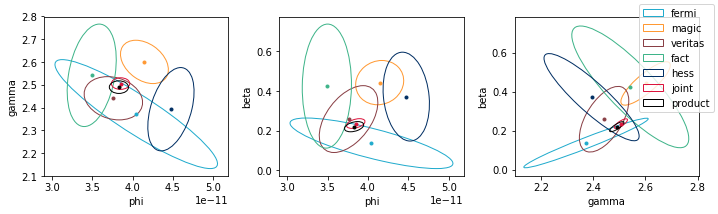

In [77]:
def plot_ellipses_panel(results, names, ax):
    colors = ["#21ABCD", "#FF9933", "#893F45", "#3EB489", "#002E63", "crimson", "black"]
    for name, color in zip(results, colors):
        m = results[name].marginal(names)
        ellipse = m.to_matplotlib_ellipse(ec=color, fc='none', label=name)
        ax.add_patch(ellipse)
        ax.plot(m.mean[0], m.mean[1], ".", color=color)
    ax.set_xlabel(names[0])
    ax.set_ylabel(names[1])


def plot_ellipses(results):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
    plot_ellipses_panel(results, ["phi", "gamma"], axes[0])
    plot_ellipses_panel(results, ["phi", "beta"], axes[1])
    plot_ellipses_panel(results, ["gamma", "beta"], axes[2])
    fig.legend()
    fig.tight_layout()

plot_ellipses(results)

As mentioned at the start, we can see that the joint fit result is approximately given by the product of the multivariate normal approximation for the fit result of each individual dataset in this analysis.

## SED

TODO: describe

In [78]:
samples = Table.read('results/errorbands/samples_veritas.fits.gz')
sed = Table.read('results/errorbands/sed_veritas.ecsv')

In [79]:
samples.info()

<Table length=500>
   name    dtype  shape       unit     
--------- ------- ----- ---------------
amplitude float64                      
reference float64                      
    alpha float64                      
     beta float64                      
   energy float64 (81,)             TeV
     dnde float64 (81,) 1 / (cm2 s TeV)


In [80]:
sed.info()

<Table length=81>
     name      dtype        unit      format
------------- ------- --------------- ------
       energy float64             TeV     3g
    dnde_mean float64 1 / (cm2 s TeV)     3g
  dnde_median float64 1 / (cm2 s TeV)     3g
      dnde_lo float64 1 / (cm2 s TeV)     3g
      dnde_hi float64 1 / (cm2 s TeV)     3g
     dnde_fit float64 1 / (cm2 s TeV)     3g
   e2dnde_fit float64   erg / (cm2 s)     3g
  e2dnde_mean float64   erg / (cm2 s)     3g
e2dnde_median float64   erg / (cm2 s)     3g
    e2dnde_lo float64   erg / (cm2 s)     3g
    e2dnde_hi float64   erg / (cm2 s)     3g
